## Microgrid simulator
    Object-oriented light framework to run custom microgrid resources in lockstep and plot/aggregate results.
    All units are s|W|Ws if not stated otherwise, more about conventions in the glossary.


# Table of contents
1. [Parameters](#si3Eitei)
2. [Model toolset](#eid8ieWi)  
3. [Tests](#Dei4Uezu)     
3. [Example](#arg4Uezu)     
4. [Appendix](#aeZae4ai)  
    4.0. [Glossary](#aec2ieTe)  
    4.1. [Notebook version](#aeDae4ai)  
    4.2. [License](#aeZGe4ai)
    

### Model Toolset <a name="eid8ieWi"></a>
    Helper functions to build the model

In [1]:
import math
import random
import time
import os
from collections import OrderedDict
from collections.abc import Iterable

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace#for ipdb
from IPython.core.display import display, HTML, clear_output

In [2]:
display(HTML("<style>.container { width:98% !important; }</style>"))#this cell width

In [3]:
%matplotlib inline
np.seterr(all='raise')
plt.rcParams["figure.figsize"] = (15,2.5)

In [4]:
VERBOSE = 0
# control verbose level of simulation_load/store/init/run()
#     0:= silent
#     1:= stringify each resource each step
#     2:= 1 with repr() instead of str()

#### Parameters

#### Helper functions and resources

In [5]:
def to_kWh(E_in):
    """takes [Ws]"""
    return E_in /1000 /3600
def to_Ws(E_in):
    """takes [kWh]"""
    return E_in *1000 *3600

In [6]:
def get_params(param, ct_grp='', j=None):
    """Calculates given parameter p for each timestep k. It implements given formulas
    takes param which is the parameter of interest, str
    takes ct_grp which specifies the collection from the magg, defaults to all in R, str
    takes j specifying the entity in the collection, defaults to all in ct_grp, int
    returns param_k in 1,K-ndarray
    no-side effects;
    """
    param = param.upper()
    if ct_grp == '' and j is not None:
        raise ValueError(f'no ct_grp selected yet j={j} given')
    if param == 'SDR':
        if ct_grp == '':#lookup mrss
            P_k_prod = get_power(ct_rs=None, ct_flow='prod')
            P_k_cons = get_power(ct_rs=None, ct_flow='cons')
            if P_k_prod is None:
                P_k_prod = np.zeros( (Resource.K) )
            if P_k_cons is None:
                P_k_cons = np.zeros( (Resource.K) )
            E_k_loss_grid = 0
            SDR_k = np.ones( (Resource.K) )
            dividend = (-1 * P_k_cons + E_k_loss_grid)
            np.divide(P_k_prod, dividend, out=SDR_k, where=dividend!=0)#to go around ZeroDivisionError
            return SDR_k
        else:
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='prod')#j=(j or None), indicated by _
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='cons')
            SDR_k_ = np.ones( (Resource.K) )
            dividend = (-1 * P_k_cons_)
            np.divide(P_k_prod_, dividend, out=SDR_k_, where=dividend!=0)
            return SDR_k_
    elif param == 'SSR':
        SDR_k_ = get_params('SDR', ct_grp, j)
        return np.where(SDR_k_ <= 1, SDR_k_, 1) 
    elif param == 'SCR':
        SDR_k_ = get_params('SDR', ct_grp, j)
        return np.where(SDR_k_ >= 1, 1/SDR_k_, 1)
    elif param == 'RCR':
        if ct_grp == '':
            P_k_prod = get_power(ct_rs=None, ct_flow='prod')
            P_k_cons = get_power(ct_rs=None, ct_flow='cons')
            if P_k_prod is None:
                P_k_prod = np.zeros( (Resource.K) )
            if P_k_cons is None:
                P_k_cons = np.zeros( (Resource.K) )
            P_k_res = np.absolute(P_k_prod + P_k_cons)
            P_k_res_abs = np.absolute(P_k_prod) + np.absolute(P_k_cons)
            out = np.zeros( (Resource.K) )
            np.divide(P_k_res, P_k_res_abs, out=out, where=P_k_res_abs!=0)
            return 1 - out
        else:
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='prod')
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_rs=None, ct_flow='cons')
            P_k_res_ = np.absolute(P_k_prod_ + P_k_cons_)
            P_k_res_abs_ = np.absolute(P_k_prod_) + np.absolute(P_k_cons_)
            out = np.zeros( (Resource.K) )
            np.divide(P_k_res_, P_k_res_abs_, out=out, where=P_k_res_abs_!=0)
            return 1 - out
    else:
        raise NotImplementedError(f'{param}')
        
def get_param(param, ct_grp='', j=None):
    """Calculates given parameter p for the simulated time; implements given formulas
    takes param which is the parameter of interest, str
    takes ct_grp which specifies the collection from the magg, defaults to all in R, str
    takes j specifying the entity in the collection, defaults to all in ct_grp, int
    returns param value
    side effects: reads from current mdata
    """
    param = param.upper()
    if ct_grp == '' and j is not None:
        raise ValueError(f'no ct_grp selected yet j={j} not None')
    if param == 'SDR':
        return np.mean(get_params(param, ct_grp, j))
    elif param == 'SSR':
        if ct_grp == '':
            P_k_res = get_power()
            P_k_res_cons = np.where(P_k_res < 0, P_k_res, 0)
            P_k_cons = get_power(ct_flow='cons')
            if np.sum(P_k_cons) != 0:
                return 1 - np.sum(P_k_res_cons) / np.sum(P_k_cons)
        else:#calc is equal to: (pv+dch)/(ld+ch+inv_loss), es loss is to be excl.
            P_k_res_ = get_power_grp(ct_grp, j=j)
            P_k_res_cons_ = np.where(P_k_res_ < 0, P_k_res_, 0)
            P_k_cons_ = get_power_grp(ct_grp, j=j, ct_flow='cons')
            if np.sum(P_k_cons_) != 0:
                return 1 - np.sum(P_k_res_cons_) / np.sum(P_k_cons_)
        return 1#no cons means no res_cons
    elif param == 'SCR':
        if ct_grp == '':
            P_k_res = get_power()
            P_k_res_prod = np.where(P_k_res > 0, P_k_res, 0)
            P_k_prod = get_power(ct_flow='prod')
            if np.sum(P_k_prod) != 0:
                return 1 - np.sum(P_k_res_prod) / np.sum(P_k_prod)
        else:
            P_k_res_ = get_power_grp(ct_grp, j=j)
            P_k_res_prod_ = np.where(P_k_res_ > 0, P_k_res_, 0)
            P_k_prod_ = get_power_grp(ct_grp, j=j, ct_flow='prod')
            if np.sum(P_k_prod_) != 0:
                return 1 - np.sum(P_k_res_prod_) / np.sum(P_k_prod_)
        return 1#no prod means no res_prod
    elif param == 'RCR':
        return np.mean(get_params(param, ct_grp, j))
    elif param == 'GUR':
        if ct_grp == '':
            raise NotImplementedError(f'{param}: choose ct_grp')
        else:
            P_k_J_res = np.zeros( (Resource.K) )
            P_k_RJ_res = np.zeros( (Resource.K) )
            if j is None:#all j
                j_ = range(len(magg[ct_grp]))
            else:#one j
                j_ = [j]
            for j__ in j_:
                P_k_J_res += np.absolute(get_power_grp(ct_grp, j=j__))
                P_k_RJ_res += get_power_grp(ct_grp, j=j__, ct_flow='prod')
                P_k_RJ_res += get_power_grp(ct_grp, j=j__, ct_flow='cons')*-1
            if P_k_RJ_res.sum() != 0:
                return P_k_J_res.sum() / P_k_RJ_res.sum()
        return 1#no RJ_res means no J_res, since |x|+|y| is 0, so is |x+y|
    else:
        raise NotImplementedError(f'{param}')        

In [7]:
def arc_to_deg(arc):
    """convert spherical arc length [m] to great circle distance [deg]"""
    return float(arc)/6371/1000 * 180/math.pi

def deg_to_arc(deg):
    """convert great circle distance [deg] to spherical arc length [m]"""
    return float(deg)*6371*1000 * math.pi/180

def latlon_to_xyz(lat,lon):
    """Convert angluar to cartesian coordiantes
     
    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = math.pi/2 - math.radians(lat) 
    phi = math.radians(lon)
    x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
    y = r * math.sin(theta) * math.sin(phi)
    z = r * math.cos(theta)
    return [x,y,z]

def xyz_to_latlon (x,y,z):
    """Convert cartesian to angular lat/lon coordiantes"""
    r = math.sqrt(x**2 + y**2 + z**2)
    theta = math.asin(z/r) # https://stackoverflow.com/a/1185413/4933053
    phi = math.atan2(y,x)
    lat = math.degrees(theta)
    lon = math.degrees(phi)
    return [lat,lon]

def gen_coords(seed, N, center=(500,500), edge=1000, is_latlon=False):
    """Generates batch of coords inside a square
    with specified edge length [m] and its center
    
    takes seed to reproduce batch, int
    takes N is batch size of tupels
    takes center of square, [m]
    takes edge length of square
    takes is_latlon bool flag
    returns N,2 ndarray
    """
    half_edge = (float(edge) / 2)
    if is_latlon:
        half_edge /= (6371 * 1000 * math.pi/180)#to deg
        if abs(center[0])+ half_edge > 90:#reject unhandled corner-cases
            raise ValueError('bad lat center due to cornercase')
        if abs(center[1])+ half_edge > 180:
            raise ValueError('bad lon center due to cornercase')
    np.random.seed(seed)#to reproduce batch
    batch = np.random.random(2 * N).reshape(2, N)#[0;1[
    batch[0] = (center[0] - half_edge) + batch[0] * half_edge * 2
    batch[1] = (center[1] - half_edge) + batch[1] * half_edge * 2
    return batch.transpose()

def center_point(resources):
    """calculate the coordinate center of rss batch
    
    takes resources list
    each dimension is averaged on arithmetic mean
    returns the center (x,y,z)
    (if: for latlon see geopy.distance.great_circle or geopy.geocoders)
    """
    center = [0,0,0]
    for rs in resources:
        xyz = latlon_to_xyz(rs.cord2, rs.cord1)
        center[0] += xyz[0]
        center[1] += xyz[1] 
        center[2] += xyz[2]
    center[:] = [axis / len(resources) for axis in center]
    return center

In [8]:
def sample_sinus(steps, period=2*math.pi, phase=0, amp=1, offset=0):
    """Sample specified sinus-wave into array
    
    takes period and phase in radians;
    takes amplitude and offset to scale and move up/down
    returns flat ndarray of steps length
    """
    assert steps != 0
    samples = np.zeros( (steps) , dtype=np.float64)#default
    step_size = period / steps
    for i in range(steps):
        samples[i] = amp * math.sin(phase + step_size * i) + offset
    return samples

def sample_recs(recs, repeat=1):
    """Builds rectangular pattern
    
    takes recs in .,3 ndarray used to build the pattern
        start,length are non-negative integers
        amp is integer
        eg [[start,length,amp],[0,4,2],[2,1,-1]]
    takes repeat to concat the period repeat times
    returns flat ndarray with specified pulse
    """
    size = recs[:,:2].sum(1).max()#number of elements 
    pattern = np.zeros( (size) )
    for rec in recs:
        start = rec[0]
        end = rec[0] + rec[1]
        amp = rec[2]
        pattern[start:end] += amp
    return np.tile(pattern, repeat)#clone and concat

In [9]:
def get_rss(ct_grp, j=None, ct_rs=None):
    """Access helper to return resources by j
    takes ct_grp which is a key from magg, str
    takes j the positional index the entity has in the magg, None is all, int
    takes ct_rs to include only resources of this category, None is all, str
        eg get_rss('hh', 1, 'es') 
            gets prosumed power es of second entity in magg['hh']
    returns list of resources of j/all and [] if no such resource(s)
    side-effect: reads from mrss,magg,mmap
    """
    ret_val = []
    if j is None:#get rss of all j
        allr_of_js = magg[ct_grp]
    else:#get rss of j
        allr_of_js = [magg[ct_grp][j]]
    for allr_of_j in allr_of_js:
        for r in allr_of_j:
            if r not in mmap:
                raise KeyError(f'magg[{j}] has r={r}, which is not in mrss')
            location = mmap[r]
            rs = mrss[location[0]][location[1]]
            if ct_rs is not None and ct_rs != rs.ct:
                continue
            ret_val.append(rs)
    return ret_val
    
def get_power(ct_rs=None, ct_flow=None):
    """Access helper to aggregate resource logs 
    takes ct_rs to include only resources of this category, None is all, str
        if ct_rs does not exist, power returned 0 and no raise
    takes ct_flow to include only 'prod' or 'cons', None is both, str
        eg get_power('es') 
            gets prosumed power of all es
    returns power in 1,K ndarray, and 1,K zeros if no such resource(s)
    side-effect: reads from mrss
    """
    ret_val = np.zeros( (Resource.K) )
    for key, value in mrss.items():
        for rs in value:
            if ct_rs is not None and ct_rs != rs.ct:#wrong rs type
                continue
            if rs.log_index_P is None:
                #print('log_index_P',rs)#prints eg inverters
                continue
            tmp = rs.view[rs.log_index_P]#select power
            if ct_flow is None:
                ret_val += tmp
            elif ct_flow == 'prod':
                ret_val += np.where(tmp > 0, tmp, 0)
            elif ct_flow == 'cons':
                ret_val += np.where(tmp < 0, tmp, 0)
            else:
                raise ValueError(f"no such flow '{ct_flow}'")
    return ret_val
    
def get_power_grp(ct_grp, j=None, ct_rs=None, ct_flow=None):
    """Access helper to aggregate resource logs by j
    takes ct_grp which is a key from magg, str
    takes j the positional index the entity has in the magg, None is all, int
    takes ct_rs to include only resources of this category, None is all, str
    takes ct_flow to include only 'prod' or 'cons', None is both, str
        eg get_power_grp('hh', 1, 'es') 
            gets prosumed power es of second hh in magg['hh']
    returns power in 1,K ndarray, and 1,K zeros if no such resource(s)
    side-effect: reads from mrss,magg,mmap
    """
    if ct_grp not in magg:
        raise ValueError(f"ct_grp '{ct_grp}' not in magg")
    ret_val = np.zeros( (Resource.K) )
    if j is None:#get rss of all j
        allr_of_js = magg[ct_grp]
    else:#get rss of j
        allr_of_js = [magg[ct_grp][j]]
    for allr_of_j in allr_of_js:
        for r in allr_of_j:
            if r not in mmap:
                raise KeyError(f'magg[{j}] has r={r}, which is not in mrss')
            location = mmap[r]
            rs = mrss[location[0]][location[1]]
            if ct_rs is not None and ct_rs != rs.ct:
                continue
            if rs.log_index_P is None:
               # print('log_index_P',rs)
                continue
            tmp = rs.view[rs.log_index_P]#select power
            if ct_flow is None:
                ret_val += tmp
            elif ct_flow == 'prod':
                ret_val += np.where(tmp > 0, tmp, 0)
            elif ct_flow == 'cons':
                ret_val += np.where(tmp < 0, tmp, 0)
            else:
                raise ValueError(f"no such flow '{ct_flow}'")
    return ret_val

In [10]:
def plot_cords(rsss, colors=None, is_latlon=False):
    """plots resources by their geospatial coordinates
    
    takes rsss list of resource lists, eg [[pv0,pv1,..],[ld]]
    takes colors list, strings from matplotlib eg ['red','green',..]
    takes is_latlon flag, bool
    each rss list is offset to prevent overpainting dots
    """
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    for rss,m in zip(rsss, range(len(rsss))):
        cords = np.zeros( (len(rss), 2) )
        for i in range(len(rss)):
            cords[i] = [rss[i].cord1+m*3, rss[i].cord2+m*3]
        if colors is None:
            plt.scatter(cords[:,0], cords[:,1])
        else:
            if len(colors) != len(rsss):
                raise ValueError(f'number of colors dont match number of rss')
            plt.scatter(cords[:,0], cords[:,1], color=colors[m])
    axs.set_aspect('equal')
    axs.grid(True)
    axs.set_title('resource locations [cord1, cord2]')
    if is_latlon == True:
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        print((f'x_resolution {deg_to_arc(xticks[2] - xticks[1]):.0f}m ' +
              f'y_resolution {deg_to_arc(yticks[2] - yticks[1]):.0f}m'))
    plt.show()

def plot_logs(rss=[], nums=[], titles=[], use_area=True):
    """Plots one log per given resource. wraps plot_bar
    takes rss resources, list
    takes nums to pick one log of the resource at the same rss position, list
    takes titles for log, optional, list of strings
    takse use_area for fast area plot instead of bars, bool
    """
    if type(rss) != list:
        raise TypeError(f'rss bad type {type(rss)}')
    if type(nums) != list:
        raise TypeError(f'nums bad type {type(nums)}')
    if len(rss) != len(nums):
        raise ValueError(f'length not equal rss:{len(rss)} nums:{len(nums)}')
    if len(titles) < len(rss):
        titles.extend(['']*(len(rss)-len(titles)))
    for rs, num in zip(rss, nums):
        if num >= len(rs.log_titles):
            print(f'num {num} out of bounds for {rs}')
    logs =  [None] * len(rss)
    for i,rs,idc,title in zip(range(len(rss)), rss, nums, titles):#pull logs out of rss
        logs[i] = rs.view[idc]
        titles[i] = rs.log_titles[idc] + ' ' + title
    plot_bar(logs, titles, use_area)

def plot_bar(ys=[[]], titles=[''], use_area=False):
    """Plots multiple data series. wraps pyplot bar
    takes list of y lists, eg [[1,2], [3,4]]
    takes titles which get appended to each plot title; list of str
    takes use_area to use area instead of bars, boolean
    """
    if not isinstance(ys[0], Iterable):
        raise TypeError(f"'ys' not a list of lists, wrap even one y, eg [[1,2],], have {type(ys[0])}")
    if not isinstance(titles[0], Iterable):
        raise TypeError(f"'titles' not a list of lists, wrap even on one y, eg [[1,2],], have {type(titles[0])}")
    if len(titles) < len(ys):#extend for zip
        titles.extend('-' * (len(ys)-len(titles)))

    fig, axs = plt.subplots(len(ys),1, figsize=(15,len(ys)*2.5), sharex=True)
    if not isinstance(axs,np.ndarray):
        axs = np.array( [axs] )
    for ax,y,title in zip(axs,ys,titles):
        ax.set_title(title)
        x = np.arange(len(y))
        if use_area:
            ax.fill_between(x, y, color='blue', alpha=0.3)
        else:
            ax.bar(x, y, width=1, align='edge', color='ghostwhite', edgecolor='grey')
    plt.show()            

In [11]:
def print_(keys_values):
    """verbose helper"""
    line = ''
    for key,value in keys_values:
        if VERBOSE == 1:
            line += f'{key}={value}, '
        elif VERBOSE == 2:
            line += f'{repr(key)}={repr(value)}, '
    if line:
        print(line)

def _views_to_mrss(mdata):
    """used internally, see function simulation_load"""
    r_set = set()
    for key, value in mrss.items():#set data
        for i in range(len(value)):
            view = mdata[key][i]#get slice of cuboid
            mrss[key][i].set_view(view)#set to resource
            if value[i].r in r_set:#check that r is unique
                raise ValueError(f'r of {value[i]} already in use')
            else:
                r_set.add(value[i].r)
            print_([[key, mrss[key][i]]])#ct_grp_rs
            
def simulation_load(name):
    """push views of mdata into each resource
    
    takes name of binary file in load_store folder to load logs from.
    ensure to have the same mrss/rs structure in place 
    from when it got saved, else mdata mismatches and errors.
    rs internal states, except number of logs are irrelevant.
    same mmap,magg not needed except when calling helpers, eg get_power
    side-effect: writes to mrss,mdata
    """
    global mdata
    with open('load_store/' + name,"rb") as f:
        mdata = pickle.load(f) 
    _views_to_mrss(mdata)
            
def simulation_store(name): 
    """saves mdata to file
    
    takes name to create file in load_store folder to binary dump.
    overwrites existing file 
    """
    with open('load_store/' + name,"wb") as f:
        pickle.dump(mdata,f)
            
def simulation_init():
    """Generates references alias numpy-views from the data model
    and saves them to each resource in the resource model.
        eg mrss['hh_ld'][0].view[1] --views--> mdata['hh_ld'][0][1]
        
    Also generates lookup table mmap used internally for 'no-search'
    in helper functions when associating resources to collections in magg.
    returns mdata, mmap
    side-effect: reads mdata, writes mrss
    """
    mdata = {}
    for key, value in mrss.items():#allocate data
        if len(value) == 0:
            print(f'please remove empty key {key} from mrss')
        cuboid = np.zeros( (len(mrss[key]), len(mrss[key][0].log_titles), Resource.K) )
        mdata[key] = cuboid
    _views_to_mrss(mdata)
    
    mmap = {}
    for key, value in mrss.items():#access map
        for i in range(len(value)):
            location = (key, i)
            mmap[value[i].r] = location
    return mdata, mmap        

def jump_back(k):
    """Calls jump() on each rs,
    errors if at least one rs did not overwrite base class
    """
    for key, value in mrss.items():
        for rs in value:
            print_([['k',k], [key, rs]])
            rs.jump(Control.jump_to_k)
    return Control.jump_to_k, None#reset flag
            
def simulation_run(up_to_k, clear_output_=True):
    """Runs the simulation for simulated_time = K * kclock
    takes up_to_k to run the simulation up to but excluding this value, int
    side-effect write/read on mdata/mrss
    """
    if 'ctrl' in mrss and next(iter(mrss.keys())) != 'ctrl':
        raise KeyError(f"key 'ctrl' in dict not first")
        
    k = 0#global counter
    time_start = time.time() 
    for key, value in mrss.items():#init round
        for rs in value:
            rs.init()
            print_([['init','-'], [key, rs]])
    while k < up_to_k:
        for key, value in mrss.items():#rs step ahead of global count
            for rs in value:
                print_([['k',k], [key, rs]])
                rs.step(k)#local step
        if clear_output_:
            clear_output(wait=True)
        time_yet = (time.time() - time_start) / (k+1) * (up_to_k-k-1)#[s] elapsed time per step * steps_yet
        print(f'progress k {k}  {k+1}/{up_to_k} {(k+1)/up_to_k*100:.0f}%  rem {time_yet/60:.2f}m')                
        k += 1#progress global time
        if Control.jump_to_k is not None:#jump requested
            k,Control.jump_to_k = jump_back(k)
    for key, value in mrss.items():#ended round, k == up_to_k
        for rs in value:
            rs.end(k)
            print_([['k',k], [key, rs]])

In [12]:
class Resource:
    """Base class to build grid components. 
    Each resource has a unique number r and is at simulation step _k.
    The time-log aggregates simulation results for later analysis.
    """
    K = None
    kclock = None#[s] see notation 
    
    def __init__(self, r, ct, cord1=0., cord2=0.):
        """takes r to identify resource, unique, int
        takes ct to specify category of this resource, str
        takes coordinates, float, optional;
            cord1/cord2 for x/y or lon/lat
        """
        assert Resource.K is not None, 'set K first'
        assert Resource.kclock is not None, 'set kclock first'
        self.r = r
        self.ct = ct                
        self.cord1 = cord1            
        self.cord2 = cord2
        self._k = 0
        self.view = None#simulation_init

    def __repr__(self):
        return (f'Resource(r={self.r}, ct={self.ct}, ' +
                f'cord1={self.cord1}, cord2={self.cord2}, K={self.K}, _k={self._k}, kclock={self.kclock})')
    
    def __str__(self):
        return (f'Resource(r={self.r}, ct={self.ct}, cord1={self.cord2}, cord2={self.cord1})')

    def set_view(self, view):
        """Hands in data each resource operates on; Done by simulation_init
        """
        self.view = view
        
    def jump(self, k):
        """Set the state to k; to be overwritten by subclasses
        takes k the timepoint to set the state to, k >= 0 and k <= current k
        
        Called after each resource concluded the last step and gets
        reset to the state at jump_to_k ktime. 
        Ctrl is the first to be rolled back.
        """
        raise NotImplementedError(f'on {self}')
    
    def init(self):
        """Called before simulation starts stepping
        """
        
    def end(self,K):
        """Called once after simulation ended, eg to assert etc
        """
    def get_k(self):
        """Returns local k
        """
        return self._k  
    
    def set_k(self, k):
        """Returns local k
        """
        self._k = k
    
    def step(self, k):
        """Perform state transition and run local time behavior.
        
        Progress time on this resource to run step of global counter k
        which runs it to k+1 ktime moving it 1 kspan forward
        function to be sub-class @extended and called right at start
        """
        if k != self._k:
            raise ValueError((f'out-of-step self._k={self._k} != '+
                              f'k={k}, please re-initialize resource model mrss'))
        else:
            self._k += 1
            
class TimeSeries(Resource):
    """Predefined power specialized resource
    """
    log_titles = (#number of logs read/written during simulation
        'P_pros [W]',#0 := produced/consumed power
        'E_pros [Ws]'#1 := produced/consumed energy
    )
    log_index_P = 0#logs index for power prosumed, else None
    
    def __init__(self, *args, **kwargs):
        super(TimeSeries, self).__init__(*args, **kwargs)
                           
    def __repr__(self):#Optional
        return (f'TimeSeries({super(TimeSeries, self).__repr__()}), ' +
                f'log_index_P={self.log_index_P}, logs)')

    def __str__(self):#Optional
        return (f'TimeSeries({super(TimeSeries, self).__repr__()})')
        
    def jump(self, k):#Optional
        """see base class"""
        local_k = self.get_k()
        if k > local_k:
            raise ValueError(f'k {k} greater than local k {local_k}')
        if k < local_k:#rolling logs/variables back to k
            self.view[1,k:] = 0
            self.set_k(k)
            
    def step(self,k):
        Resource.step(self, k)
        E_prod = self.view[0,k] * Resource.kclock
        self.view[1,k] = E_prod
            

class Control(Resource):
    """Implements microgrid control logic, blueprint
    """
    log_titles = ('P_foo [W]',
                 )
    log_index_P = None#index in log_titles that logs power prosumed
    
    jump_to_k = None#set simulation time back to/including k.
    #eg current k is 10 and back to 5 makes all rss finish 10 and jump to 5
    #useful for eg back-tracking; can be called multiple times; call anywhere in step()
    
    def __init__(self, **kwargs):
        super(Control, self).__init__(**kwargs)
        
    def __repr__(self):
        return (f'Control({super(Control, self).__repr__()})')

    def __str__(self):
        return (f'Control({super(Control, self).__repr__()})')
    
    def jump(self, k):
        """see base class
        """
        local_k = self.get_k()
        if k > local_k:
            raise ValueError(f'unable to roll to future, k {k} greater than local k {local_k}')
        if k == 0:
            self.view[:,k:] = 0#jump all logs
        elif k < local_k:
            self.view[:,k:] = 0
        self.set_k(k)
    
    def init(self):
        print(f'simulation about to start')
        
    def end(self, K):
        pass
        
    def step(self, k):
        Resource.step(self, k)
        """place logic here, make sure to have energy conservation in==out
        """ 
        P_bal = 0#energy conservation
        #... place logic here
        assert P_bal == 0, 'power inflow != outflow'

### Example <a name="arg4Uezu"></a>
    Two households each one pv simulated for 4 steps each 60s long; no control 

In [13]:
%%time
Resource.K = 4#take 4 steps
Resource.kclock = 60# each 60s long
mrss = OrderedDict({
    'hh_ld': [TimeSeries(r=0,ct='ld'),TimeSeries(r=1,ct='ld'),],#two loads
    'hh_pv': [TimeSeries(r=2,ct='pv'),TimeSeries(r=3,ct='pv'),],#two pvs
})
magg = {
    'hh': [[0,2],[1,3], ]#two hh, each one ld and pv
}
mdata, mmap = simulation_init()
mdata['hh_ld'][0] = sample_recs(np.array([[0,1,-10], [1,1,-10], [2,1,-5], [3,1,0]]),1)#synth profile
mdata['hh_ld'][1] = sample_recs(np.array([[0,1,-10], [1,1,-10], [2,1,-5], [3,1,0]]),1)
mdata['hh_pv'][0] = sample_recs(np.array([[0,1,10], [1,1,5], [2,1,10], [3,1,0]]),1)
mdata['hh_pv'][1] = sample_recs(np.array([[0,1,10], [1,1,5], [2,1,0], [3,1,0]]),1)
simulation_run(up_to_k=4, clear_output_=False)

progress k 0  1/4 25%  rem 0.00m
progress k 1  2/4 50%  rem 0.00m
progress k 2  3/4 75%  rem 0.00m
progress k 3  4/4 100%  rem 0.00m
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.07 ms


#### Analysis

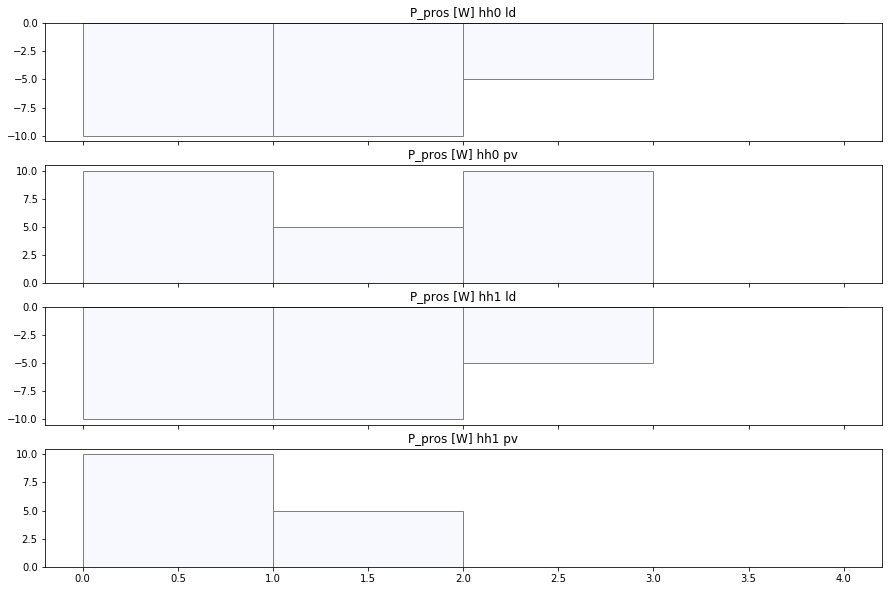

In [14]:
rss = [mrss['hh_ld'][0], mrss['hh_pv'][0], mrss['hh_ld'][1], mrss['hh_pv'][1]]
plot_logs(rss, [0,0,0,0], ['hh0 ld', 'hh0 pv', 'hh1 ld', 'hh1 pv'], use_area=False)

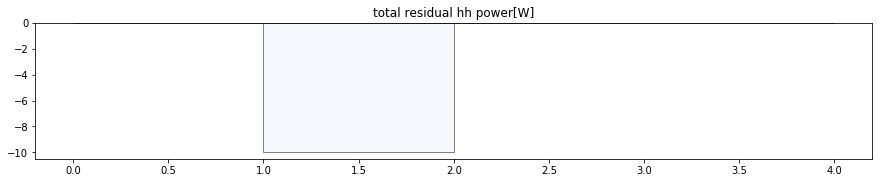

In [15]:
plot_bar([get_power_grp('hh')], ['total residual hh power[W]'])

In [16]:
f"The SSR of the community is {get_param(param='SSR', ct_grp='hh')} of total consumed {to_kWh(get_power_grp('hh', ct_flow='cons')*Resource.kclock).sum():.6f}kWh"

'The SSR of the community is 0.8 of total consumed -0.000833kWh'

### Tests <a name="Dei4Uezu"></a>

In [17]:
assert ( get_power_grp('hh') == (get_power_grp('hh', ct_flow='prod') + get_power_grp('hh', ct_flow='cons')) ).all() 
assert get_power(ct_rs='pv').all() == np.array([20,10,10,0]).all()

assert (get_params(param='SDR', ct_grp='hh', j=1) - [1,0.5,0,1]).all() == np.zeros( (Resource.K) ).all()
assert (get_params(param='SDR', ct_grp='') - [1,0.5,1,1]).all() == np.zeros( (Resource.K) ).all()
assert (get_params(param='SSR', ct_grp='') - [1,0.5,1,1]).all() == np.zeros( (Resource.K) ).all()
assert (get_params(param='SSR', ct_grp='hh', j=1) - [1,0.5,0,1]).all() == np.zeros( (Resource.K) ).all()
assert (get_params(param='SCR', ct_grp='') - [1,1,1,1]).all() == np.zeros( (Resource.K) ).all()
assert abs(get_params(param='RCR', ct_grp='hh', j=0) - [1,2/3,2/3,1]).all() < 1e-6

assert get_param(param='SDR', ct_grp='hh', j=1) - np.mean([1,0.5,0,1]) == 0
assert get_param(param='SDR', ct_grp='') - np.mean([1,0.5,1,1]) == 0
assert get_param(param='SSR', ct_grp='') - 0.8 == 0
assert get_param(param='SSR', ct_grp='hh', j=1) - 3/5 == 0
assert get_param(param='SCR', ct_grp='') - 1 == 0
assert get_param(param='SCR', ct_grp='hh', j=0) - 0.8 == 0
assert (abs(get_params(param='RCR', ct_grp='') - [1,2/3,1,1])).all() < 1e-6
assert abs(get_param(param='RCR', ct_grp='hh', j=0) - 1/4*(1+2/3+2/3+1)) < 1e-6
assert get_param(param='RCR', ct_grp='hh', j=1) - 2/3 < 1e-6

assert arc_to_deg(math.pi*6371*1000) == 180 # coordinate tests
assert deg_to_arc(180) == math.pi*6371*1000
xyz = latlon_to_xyz(90,-180)
latlon = xyz_to_latlon(xyz[0], xyz[1], xyz[2])
assert latlon[0] == 90 and latlon[1] == -180

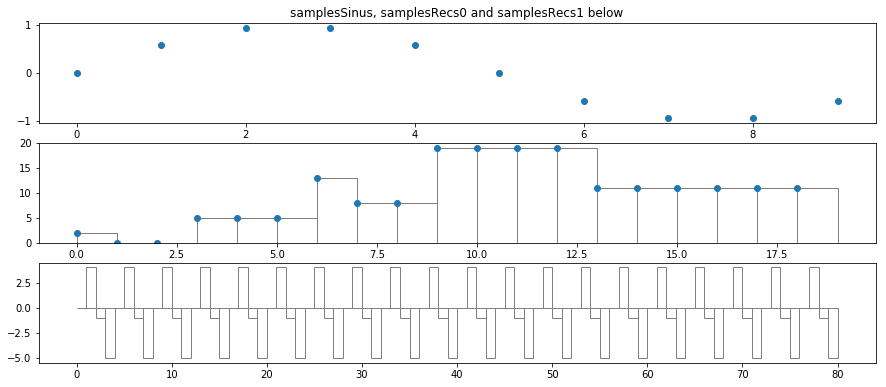

In [18]:
samplesSinus = sample_sinus(10)#test samples
samplesRecs0 = sample_recs(np.arange(12).reshape(4,3),1)
samplesRecs1 = sample_recs(np.array([[1,2,4], [2,2,-5]]),20)

fig, axes = plt.subplots(3,1, figsize=(15,2.5*2.5))#plot samples
axes[0].set_title('samplesSinus, samplesRecs0 and samplesRecs1 below')
axes[0].plot(samplesSinus, 'o')
axes[1].plot(samplesRecs0, 'o')
axes[1].bar(np.arange(samplesRecs0.size), samplesRecs0, width=1, align='edge', color='white', edgecolor='grey')
axes[2].bar(np.arange(samplesRecs1.size), samplesRecs1, width=1, align='edge', color='white', edgecolor='grey')
plt.show()

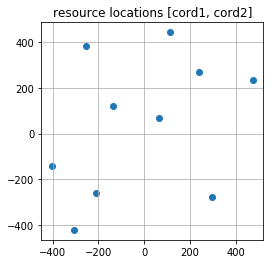

In [19]:
cords = gen_coords(center=(49.583333, 11.016667), edge=1000, N=10, seed=101)#plot resource map
rss = [Resource(i,1, cords[i][1], cords[i][0]) for i in range(10)]
plot_cords([rss])

### Appendix <a name="aeZae4ai"></a>

#### Glossary <a name="aec2ieTe"></a>
    abbreviations
        pv		photovoltaic system
        es		energy storage system
        soc		state of energy charge
        inv     inverter
        hh		household
        dof     degree of freedom
        jpn     jupyter notebook
        xfmr    transformer

        E_		energy [Ws], ∈ |R float
        P_ 		power [W], ∈ |R float
        C_		cost, <0 negative cost is revenue, >0 is cost
                    ∈ |R float denoted in [curr]
        c_		cost per unit, 
                    ∈ |R+ float, denoted in [curr/Ws]
    sub-idices  
        res		residual 
        prod    produced
        cons    consumed
        r       resource index
        r=foo   selector, only resources of type foo
        R      number of resources
        const	constant
        bal     balance
        ctrl    control  
        ch      charge
        dch     discharge
        J		collection size of ct_grp in aggregator model
        j		collection/peer index, ∈ [0;J-1]
        <type>	specifier eg load|pv|es|res|... 

    time scale
        k       simulation time counter, ∈ [0;K-1]
                increments each step to advance time
        K		number of simulation steps

        kclock  step time, maps simulation time to clock-time, ∈ |R or |N, [s]
                describes time passed each step,
                modifying the value is ok and changes granularity of the data

                modifying its unit  requires resource adjustments
                imported resource models with different step value/unit must
                    be adjusted, eg 2[ms] model must step 500* per k if kclock 1[s]
                common units are [s|m|h|d]
        units are ktime, kspan, ctime, cspan for concrete k
                at k ktime is a timepoint
                at k kspan is one timespan and starts at k ktime
                for k kspan is a timespan of length k with unspecified start

        kr      used to specify relative timespans, see examples
        ekE     divides k axis into epochs of length E ∈ |N
                e = int(k/E) converts k to epoch e
                k = e*E      converts epoch e to k

    sign convention
        <0 := outflow alias consume or export
        >0 := inflow alias produce or import
        from system point of view consumer counting arrow system
        from resource pov called producer counting arrow system
        the system is a virtual construct only for energy conservation
        the pysical grid would be a loss afflicted resource itself
        loss is always negative, since it reduces the system's energy amount 
        +------------------+
        | +--------+       |
        | |resource|<-cons |<-imp
        | +--------+->prod |->exp,
        |  system          |
        +------------------+

    examples
        P_k_res         of any k
        P_K_res, P_res  for all k summarized
        P_j_res         of any j
        P_J_res         for all j summarized, since there are multiple J's it remains;
        k2              simulation time after two steps 0-1-now
                        in text called 2 ktime or 4 ctime with kclock=2
        K * kclock      total simulated time in ctime
        P_k10,j0,load   power load of peer 0 at ktime 10
        P_j0,k1,pv      photovoltaic power of peer 0 at 1 ktime
        P_j,k1,pv       photovoltaic power of unspecified peer at 1 ktime
        P_j0:9,res      total residual power of peers [0;8]
        P_J,res         total residual power of all peers
                        time irrelevant/omitted or specified elsewhere
        P_J,pv          total photovoltaic power of all peers
        E_K,res         total residual energy over simulated time K kspan
        P_r0,k1         power of resource with index 0 at 1 ktime
        P_R             total power of all devices
                        if peers hold all resources, == P_J,res
        E_k10:20        energy sum over 10 kspan from k [10;19]
        E_kr0:10        energy sum over 10 kspan; 'when' unkown
        E_2k15          energy sum over 15 kspan from k [30;44]
 

In [20]:
%%latex
\begin{align}
E_{k} & = \intop_{k}^{k+kclock} P(t) dt = P_{k} * kclock\\
E & = (P) * kclock = (\sum_{k=1}^{K} P_{k}) * kclock = \sum_{k=1}^{K} (P_{k} * kclock) \\
\end{align}

<IPython.core.display.Latex object>

    energy power relation
        due to discretization it is constant during kclock simplifying the integral.
        energy/power calculations can be done distributive a*(b+c)= a*b+a*c 

In [21]:
%%latex
\begin{align}
P_{k,r} & = \begin{cases}
        P_{k,r,prod} \quad & \text{if } P_{k,r} \geq 0 \text{ producer}\\
        P_{k,r,cons} \quad & \text{if } P_{k,r} < 0 \text{ consumer}\\
    \end{cases}\\
P_{k,r,res}  & = P_{k,r,prod} + P_{k,r,cons} \\    
\end{align}

<IPython.core.display.Latex object>

    resource sign conventions, outflow positive, inflow negative
        addon: P_k,r,res makes only sense if one resource has two ports.

#### Power

In [22]:
%%latex
\begin{align} 
P_{k,j,prod} & = \sum_{i=1}^{R \land j} P_{k,j,i,prod} \quad \text{and}\quad  P_{k,j,cons} = \sum_{i=1}^{R \land j} P_{k,j,i,cons}\\
P_{k,j,res} & = P_{k,j,prod} + P_{k,j,cons} = \sum_{i=1}^{R \land j} P_{k,j,i} \\
P_{J,res} & = \sum_{j=1}^{J} P_{j,res}  \quad \text{and}\quad 
P_{R,prod} = \sum_{r=1}^{R} P_{r,prod}\\
\end{align}

<IPython.core.display.Latex object>

    power produced and consumed of peer j at k ktime over its own resource set 
    power residual of peer j at k ktime over its own resource set
    total power of all peers at k ktime
    total power of all resources at k ktime

### Parameters<a name="si3Eitei"></a>

In [23]:
%%latex
\begin{align}
SSR_{k,j} & = 1 - \frac{P_{k,j,res,cons}}{P_{k,j,cons}}\\
SSR_{j} & = 1 - \frac{P_{j,res,cons}}{P_{j,cons}}\\
SCR_{k,j} & = 1 - \frac{P_{k,j,res,prod}}{P_{k,j,prod}}\\ 
SCR_{j} & = 1 - \frac{P_{j,res,prod}}{P_{j,prod}}\\       
\end{align}

<IPython.core.display.Latex object>

    self-sufficiency-rate of peer j at k ktime
    self-sufficiency-rate of peer j for simulated time
    analog the self-consumption rate 

In [24]:
%%latex
\begin{align}
SDR_{k,j} & = \dfrac{ P_{k,j,prod} }{ -P_{k,j,cons} } \quad \text{if }  P_{k,j,cons} \text{ not 0 else 1}\\
SDR_{j} & = \dfrac{ P_{j,prod} }{ -P_{j,cons} }\\
SDR_{k} & = \frac{ \sum_{r=1}^{R} P_{k,r,prod} }{ -\sum_{i=1}^{R} P_{k,r,cons} }\\
SDR & = \frac{ \sum_{r=1}^{R} P_{r,prod} }{ -\sum_{i=1}^{R} P_{r,cons} }\\         
\end{align}

<IPython.core.display.Latex object>

    supply-demand-ratio of peer j at k ktime 
    supply-demand-ratio of peer j
    the second two formulas remove the peer and use the r index to make a general statement

In [25]:
%%latex
\begin{align}
RCR_{k} & = 1 - \frac{ |\sum_{j=1}^{J} P_{k,j,res}| }{ \sum_{j=1}^{J} |P_{k,j,res}| }\\
RCR_{k,j} & = 1 - \frac{ |\sum_{i=1}^{R \land j} P_{k,r}| }{ \sum_{i=1}^{R \land j} |P_{k,r}| }\\
\end{align}

<IPython.core.display.Latex object>

    residual-cancellation-rate at k ktime
        describes anticyclic relation of residual load, [0;1]
        the closer to 1 the better peers complement each other in residual power;
        describes destructive interference; if P_kJ_res = 0 the RCR_k is 1
        example for RCR = 0 and RCR = 1
            +---+         +---+
            |j0 |         |j0 |
            +-------+->   +--------->
                |j1 | k   |j1 |     k
                +---+     +---+
    residual-cancellation-rate of peer j at k ktime
        if P_k_Rofj = 0 the RCR_kj is 1

In [26]:
%%latex
\begin{align}
GUR_{J} & = \frac{ \sum_{k=1}^{K} \sum_{j=1}^{J} |P_{k,j,res}| }
    { \sum_{k=1}^{K} \sum_{i=1}^{R \land J} |P_{k,r}| }\\
\end{align}

<IPython.core.display.Latex object>

    grid-utilization rate
        measure for the percentage of energy flow over smart-meters from J subsystems in/out of the system; or
        total absolute residual power of all peers (P_J_res) divided by total absolute power of peer rss; or
        of all energyflow how much went over the grid

#### Loss

In [27]:
%%latex
\begin{align}
E_{k,r,loss} & = \begin{cases}
        E_{k,r,loss,ch} \quad & \text{if } P_{k,r,set} < 0 \text{ charge loss and ct_rs='es'}\\
        E_{k,r,loss,idle} \quad & \text{if } P_{k,r,set} = 0 \text{ idle loss and ct_rs='es'}\\
        E_{k,r,loss,dch} \quad & \text{if } P_{k,r,set} > 0 \text{ discharge loss and ct_rs='es'}\\
    \end{cases}\\
    
E_{k,loss,es} & = \sum_{i=1}^{|es|} E_{k,i,loss,es}\\

E_{k,loss,es,idle} & = \sum_{i=1}^{|es|} E_{k,i,loss,es,idle}\\

E_{k,j,loss,es} & = \sum_{i=1}^{|es|\land j} E_{k,j,i,loss,es}\\

E_{k,R,loss} & = \sum_{r=1}^{R} E_{k,r,loss}\\

E_{k,loss} & = E_{k,R,loss} + E_{k,loss,grid}\\
\end{align}

<IPython.core.display.Latex object>

    energy loss of resource r of category 'es' at k kspan
        since the es is only in one state, non-state losses are considered 0
    total energy loss of all es at k kspan
    total idle energy loss of all es at k kspan
    total energy loss of peer j and its es at k kspan
    total energy loss of all resources at k kspan
    total energy loss of the system at k kspan

#### Notebook version <a name="aeDae4ai"></a>
    

In [28]:
from IPython.utils.sysinfo import get_sys_info
get_sys_info()

{'ipython_version': '7.2.0',
 'ipython_path': '/home/user/.pyenv/versions/3.6.4/lib/python3.6/site-packages/IPython',
 'commit_source': 'installation',
 'commit_hash': '523ed2fe5',
 'sys_version': '3.6.4 (default, Mar 26 2018, 14:15:50) \n[GCC 6.3.0 20170516]',
 'sys_executable': '/home/user/.pyenv/versions/3.6.4/bin/python3',
 'sys_platform': 'linux',
 'platform': 'Linux-4.9.0-9-amd64-x86_64-with-debian-9.9',
 'os_name': 'posix',
 'default_encoding': 'UTF-8'}

#### License notice <a name="aeZGe4ai"></a>

    MIT License

    Copyright (c) 2019 jr

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.

    https://tldrlegal.com/license/mit-license